In [ ]:
import re  # for regular expressions
import string
from tqdm import tqdm

import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import nltk  # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models.doc2vec import TaggedDocument

import gensim

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from scipy import stats

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold


In [ ]:
# Load the dataset
cvd_df = pd.read_csv('/content/Corona_NLP_train.csv', encoding='latin-1')

In [ ]:
# Section 2: Reviewing and Exploring Dataset

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(cvd_df.head())

# Information about the dataset
print("\nInformation about the dataset:")
print(cvd_df.info())

# Shape of the dataset
print("\nShape of the dataset:", cvd_df.shape)

# Names of columns in the dataset
print("\nColumn names in the dataset:", cvd_df.columns)

# Distribution of tweets by date
print("\nDistribution of tweets by date:")
print(cvd_df['TweetAt'].value_counts())

# Unique locations from where the tweets came
print("\nUnique locations from where the tweets came:", cvd_df['Location'].nunique())

# Distribution of sentiment types
print("\nDistribution of sentiment types:")
print(cvd_df['Sentiment'].value_counts())

# Distribution of top 15 locations of tweets
print("\nDistribution of top 15 locations of tweets:")
print(cvd_df['Location'].value_counts().head(15))


First few rows of the dataset:
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  

Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         -------------- 

In [ ]:
cvd_df[cvd_df['Sentiment']=='Negative']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative
24,3823,48775,Downstage centre,16-03-2020,@10DowningStreet @grantshapps what is being do...,Negative
26,3825,48777,"Ketchum, Idaho",16-03-2020,In preparation for higher demand and a potenti...,Negative
28,3827,48779,"New York, NY",16-03-2020,Do you see malicious price increases in NYC? T...,Negative
30,3829,48781,NaN,16-03-2020,There Is of in the Country The more empty she...,Negative
...,...,...,...,...,...,...
41127,44926,89878,NaN,14-04-2020,Today at the grocery store I saw someone getti...,Negative
41131,44930,89882,"Accra, Ghana",14-04-2020,In every human affliction there are gainers a...,Negative
41147,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?...,Negative
41149,44948,89900,"Toronto, Ontario",14-04-2020,Still shocked by the number of #Toronto superm...,Negative


In [ ]:
cvd_df[cvd_df['Sentiment']=='Negative'].loc[9,'OriginalTweet']

"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona"

In [ ]:
cvd_df[cvd_df['Sentiment']=='Positive']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
...,...,...,...,...,...,...
41140,44939,89891,Pakistan,14-04-2020,Good News! \r\r\nWe'll Soon Announce Our High ...,Positive
41145,44944,89896,"Manhattan, NY",14-04-2020,How exactly are we going to re-open New York C...,Positive
41146,44945,89897,"Gurgaon, India",14-04-2020,#Gold prices rose to a more than 7-year high t...,Positive
41150,44949,89901,OHIO,14-04-2020,I never that weÂd be in a situation &amp; wor...,Positive


In [ ]:
cvd_df[cvd_df['Sentiment']=='Positive'].loc[1,'OriginalTweet']

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [ ]:
cvd_df[cvd_df['Sentiment']=='Neutral']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
10,3809,48761,"Makati, Manila",16-03-2020,All month there hasn't been crowding in the su...,Neutral
16,3815,48767,Saudi Arabia,16-03-2020,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral
17,3816,48768,"Ontario, Canada",16-03-2020,@eyeonthearctic 16MAR20 Russia consumer survei...,Neutral
...,...,...,...,...,...,...
41141,44940,89892,India,14-04-2020,#Coronavirus ?? ????? ??? ????? ?? ??? ???????...,Neutral
41143,44942,89894,In burning hell.,14-04-2020,https://t.co/8s4vKvcO1r #5gtowers?? #EcuadorUn...,Neutral
41144,44943,89895,NaN,14-04-2020,@_Sunrise_SV @Gamzap @NPR What does not having...,Neutral
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral


In [ ]:
cvd_df[cvd_df['Sentiment']=='Neutral'].loc[0,'OriginalTweet']

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [ ]:
pd.isnull(cvd_df["Sentiment"])

0        False
1        False
2        False
3        False
4        False
         ...  
41152    False
41153    False
41154    False
41155    False
41156    False
Name: Sentiment, Length: 41157, dtype: bool

# ***Analyze Null Values***

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Section 1: Looking for Null Values
def analyze_null_values(data):
    missing_values = pd.DataFrame()
    missing_values['Column'] = data.columns
    missing_values['Percent'] = [round(100 * data[col].isnull().sum() / len(data), 2) for col in data.columns]
    missing_values = missing_values[missing_values['Percent'] > 0].sort_values('Percent')

    plt.figure(figsize=(15, 5))
    sns.set(style='whitegrid')
    splot = sns.barplot(x='Column', y='Percent', data=missing_values, palette='Blues')
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.xlabel("Column", size=14, weight="bold")
    plt.ylabel("Percentage", size=14, weight="bold")
    plt.title("Percentage of missing values in each column", fontweight="bold", size=17)
    plt.show()

    plt.figure(figsize=(17, 5))
    sns.heatmap(data.isnull(), cbar=True, yticklabels=False, cmap='Blues')
    plt.xlabel("Column", size=14, weight="bold")
    plt.title("Places of missing values in each column", fontweight="bold", size=17)
    plt.show()

In [ ]:
# Section 2: Unique Values In Each Feature Column
def analyze_unique_values(data):
    unique_df = pd.DataFrame()
    unique_df['Column'] = data.columns
    unique_df['Unique_Values_Count'] = [data[col].nunique() for col in data.columns]

    plt.figure(figsize=(15, 7))
    splot = sns.barplot(x=unique_df['Column'], y=unique_df['Unique_Values_Count'], alpha=0.8, palette='Blues')
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.title('Number of unique values in each column', weight='bold', size=15)
    plt.ylabel('#Unique values', size=12, weight='bold')
    plt.xlabel('Column', size=12, weight='bold')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# Section 4: Top 10 Locations of Tweets
def plot_top_location_tweets(data):
    top_locations = data['Location'].value_counts().head(10)

    top_location_df = pd.DataFrame(top_locations)
    top_location_df.reset_index(inplace=True)
    top_location_df.rename(columns={'index': 'Location', 'Location': 'Location_Count'}, inplace=True)

    viz = sns.barplot(x="Location_Count", y="count", data=top_location_df, palette='Blues_d')
    viz.set_title('Locations with most of the tweets')
    viz.set_ylabel('Count of listings')
    viz.set_xlabel('Location Names')
    viz.set_xticklabels(viz.get_xticklabels(), rotation=45)
    plt.show()

In [ ]:
# Section 5: Sentiments Countplot
def plot_sentiments_count(data):
    sns.set(font_scale=1.1)
    sns.catplot(x="Sentiment", data=data, kind="count", height=8, palette='Blues')
    plt.show()

    data.TweetAt.value_counts()

<ipython-input-12-b49eb3d691c4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  splot = sns.barplot(x='Column', y='Percent', data=missing_values, palette='Blues')


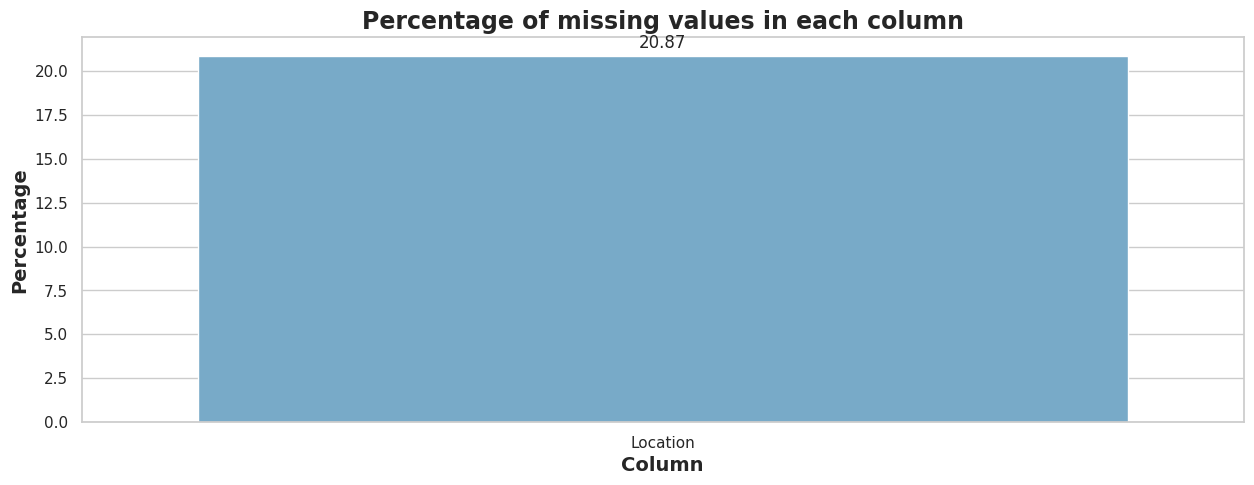

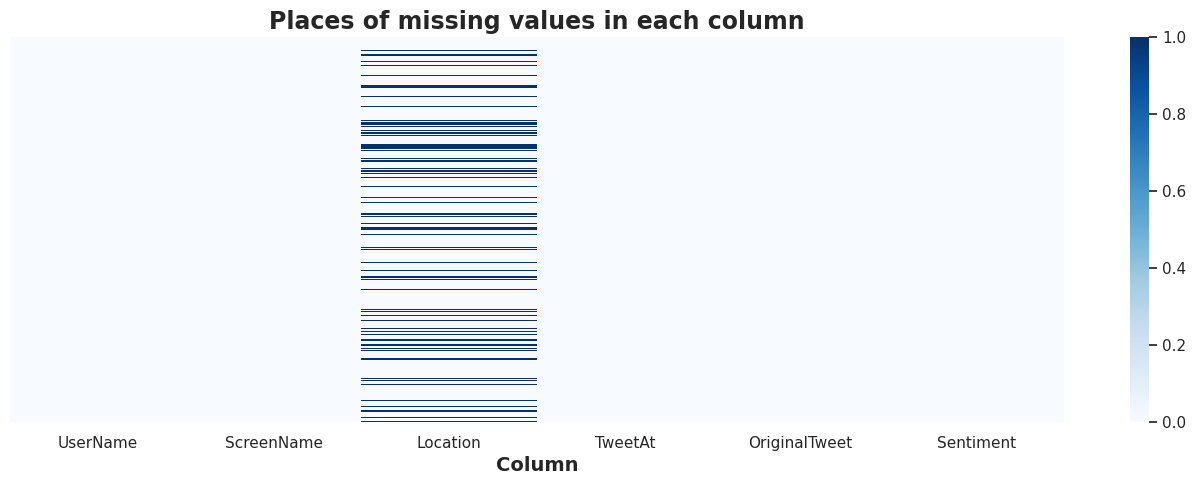

<ipython-input-13-d7e2dc7bebeb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  splot = sns.barplot(x=unique_df['Column'], y=unique_df['Unique_Values_Count'], alpha=0.8, palette='Blues')


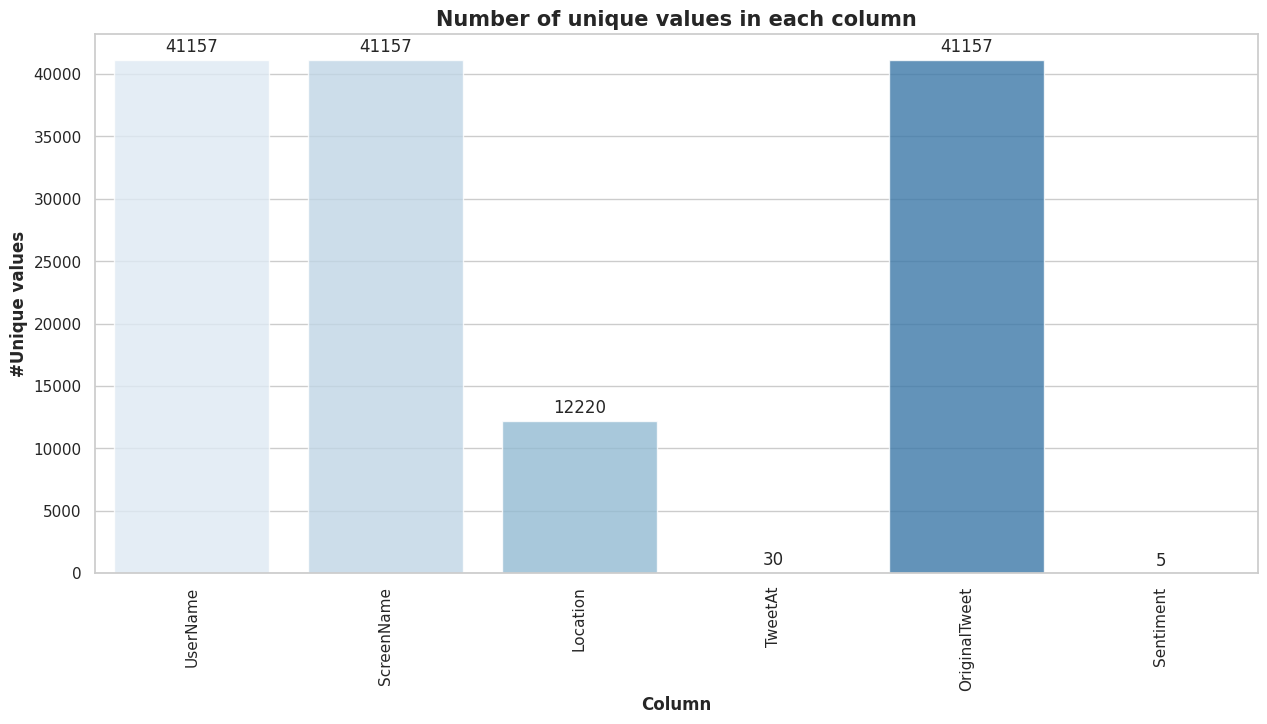

<ipython-input-14-dfd73f0f27b1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  viz = sns.barplot(x="Location_Count", y="count", data=top_location_df, palette='Blues_d')
<ipython-input-14-dfd73f0f27b1>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  viz.set_xticklabels(viz.get_xticklabels(), rotation=45)


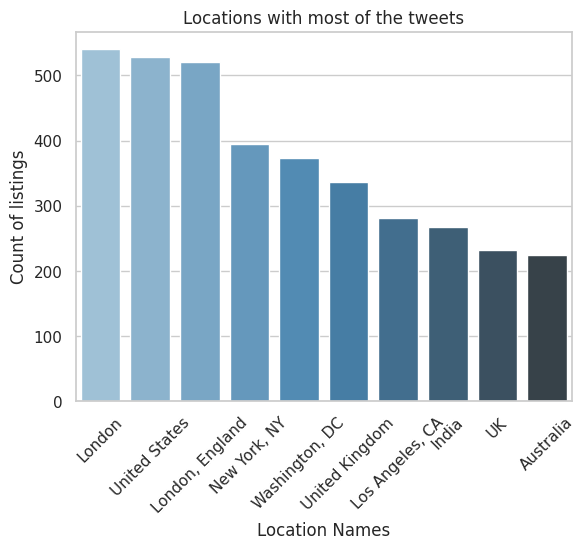

<ipython-input-15-cf1f19c508ee>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x="Sentiment", data=data, kind="count", height=8, palette='Blues')


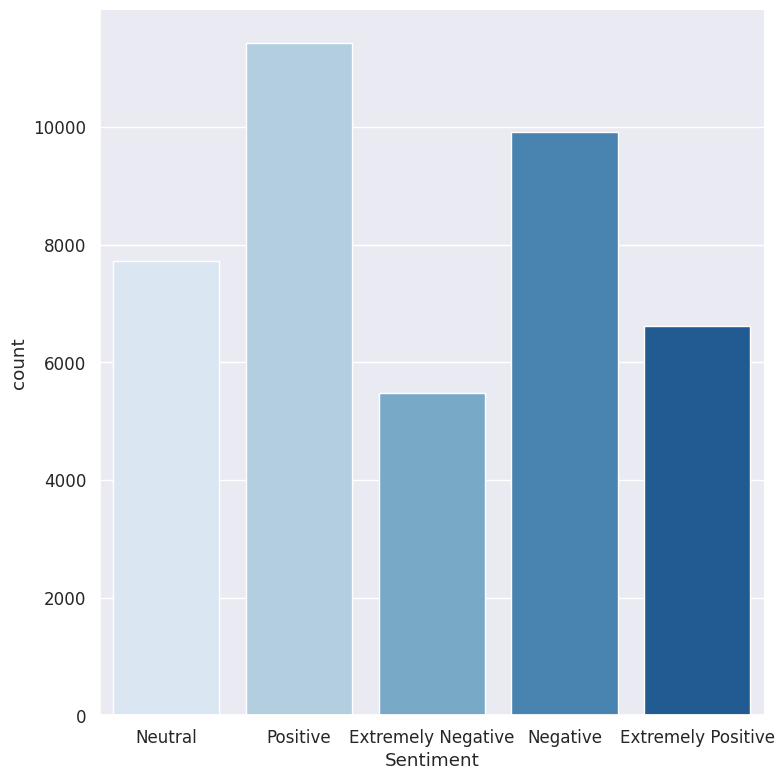

In [ ]:
# Call functions
analyze_null_values(cvd_df)
analyze_unique_values(cvd_df)
plot_top_location_tweets(cvd_df)
plot_sentiments_count(cvd_df)

In [ ]:
Top_Location_tweets= cvd_df['Location'].value_counts().head(10)

In [ ]:
Top_Location_tweets

Location
London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: count, dtype: int64

In [ ]:
Top_Location_tweets_df=pd.DataFrame(Top_Location_tweets)
Top_Location_tweets_df.reset_index(inplace=True)
Top_Location_tweets_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_tweets_df

,Location_Count,count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


# ***Data Preprocessing***

In [ ]:
def preprocess_tweets(df):
    """
    Data preprocessing steps:
    A) Removing @user
    B) Removing URLs
    C) Removing special characters, numbers, and punctuations
    D) Removing short words
    E) Tokenization
    F) Stemming

    Args:
    - df: DataFrame containing the 'OriginalTweet' column

    Returns:
    - df: DataFrame with preprocessed 'Tweet' column
    """
    # A) Removing @user
    def remove_pattern(input_txt, pattern):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt

    df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

    # B) Removing URLs
    df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

    # C) Removing special characters, numbers, and punctuations
    df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+', ' ')

    # D) Removing short words
    df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

    # E) Tokenization
    tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

    # F) Stemming
    stemmer = PorterStemmer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

    # Join tokens into one sentence
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

    # Update 'Tweet' column with tokenized and stemmed tweets
    df['Tweet'] = tokenized_tweet

    return df


In [ ]:
# Apply preprocessing function
df = preprocess_tweets(cvd_df)

# Check the first few rows of the DataFrame after preprocessing
print(df.head())

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   

                                               Tweet  
0                                                     
1  advic talk your neighbour famili exchang phone...  
2  coronaviru australia: woolworth give elderly, ...  
3  food stock not the 

# ***Impact of Hashtags on tweets sentiment***

In [ ]:
# Define a function to extract hashtags from tweets
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [ ]:
# Extract hashtags for each sentiment category
HT_Extremely_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Positive'])
HT_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Negative'])
HT_Extremely_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Negative'])

# Unnest the list of hashtags
HT_Extremely_Positive = sum(HT_Extremely_Positive, [])
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative, [])
HT_Extremely_Negative = sum(HT_Extremely_Negative, [])

In [ ]:

# Make frequency distribution for top 10 hashtags in each sentiment category
def plot_top_hashtags(HT, sentiment):
    a = nltk.FreqDist(HT)
    d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})
    d = d.nlargest(columns='Count', n=10)

    plt.figure(figsize=(16, 5))
    ax = sns.barplot(data=d, x='Hashtag', y='Count', palette='viridis')
    ax.set_title(f'Top 10 Hashtags for {sentiment} Sentiment')
    ax.set_xlabel('Hashtags')
    ax.set_ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

<ipython-input-24-e29a0a677b5b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x='Hashtag', y='Count', palette='viridis')


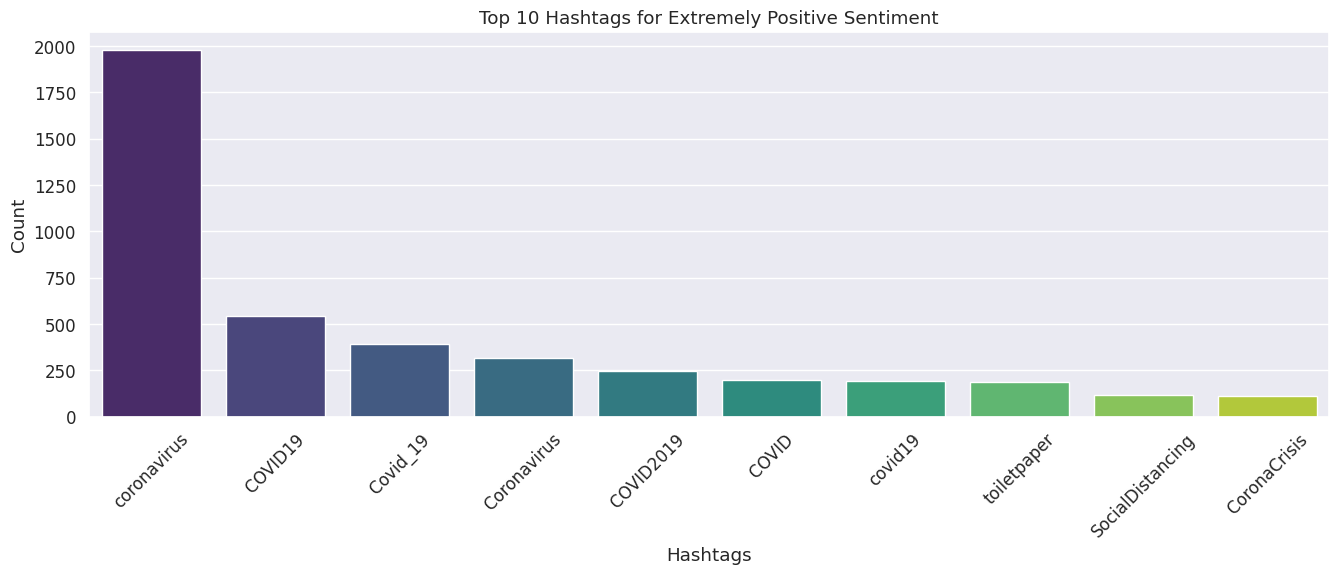

<ipython-input-24-e29a0a677b5b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x='Hashtag', y='Count', palette='viridis')


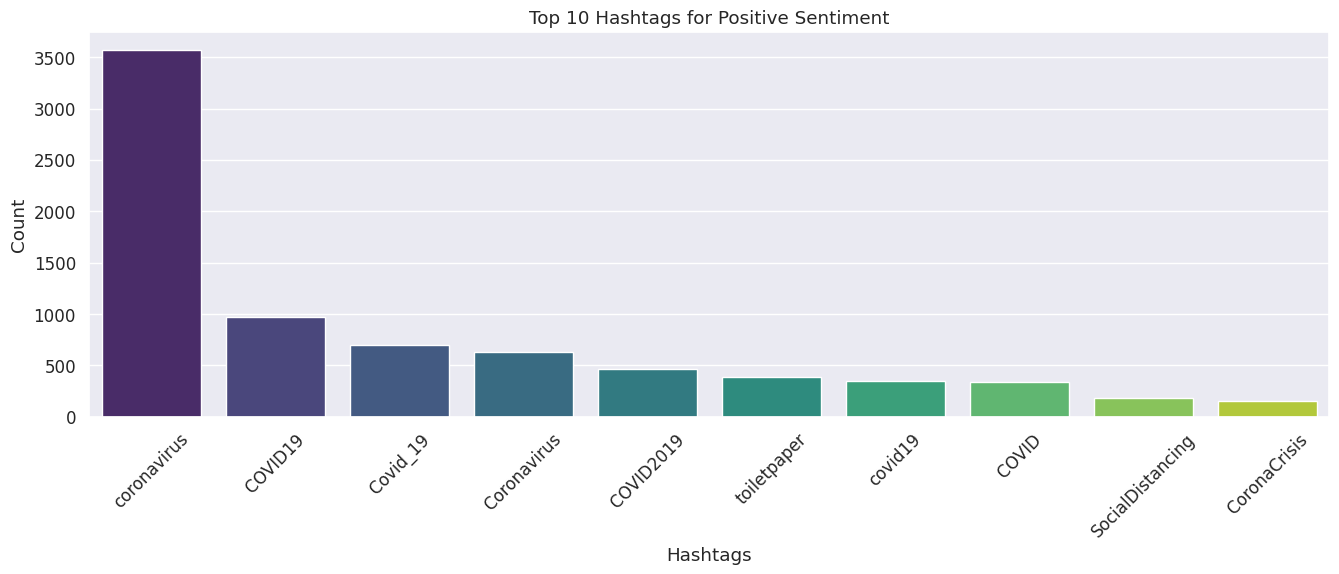

<ipython-input-24-e29a0a677b5b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x='Hashtag', y='Count', palette='viridis')


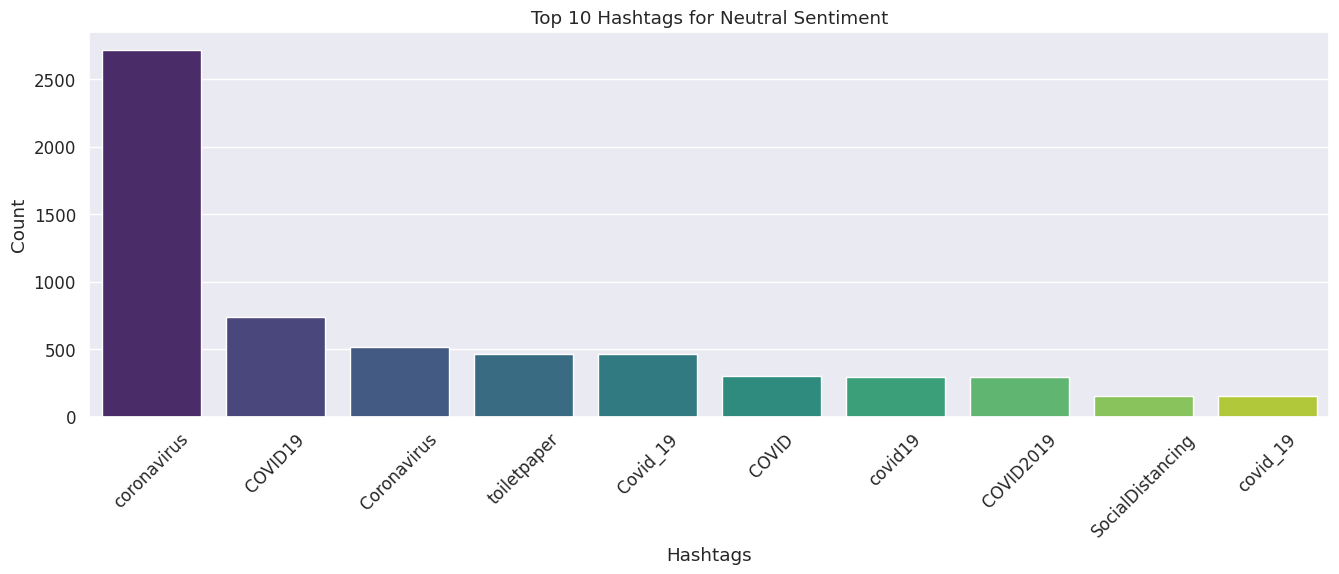

<ipython-input-24-e29a0a677b5b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x='Hashtag', y='Count', palette='viridis')


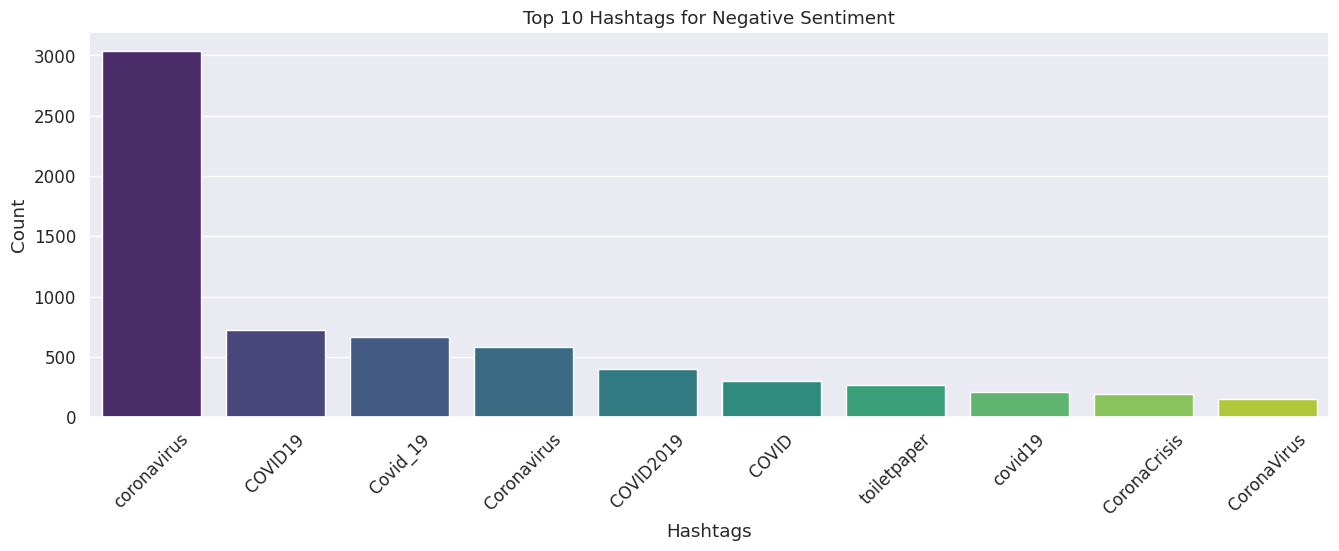

<ipython-input-24-e29a0a677b5b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x='Hashtag', y='Count', palette='viridis')


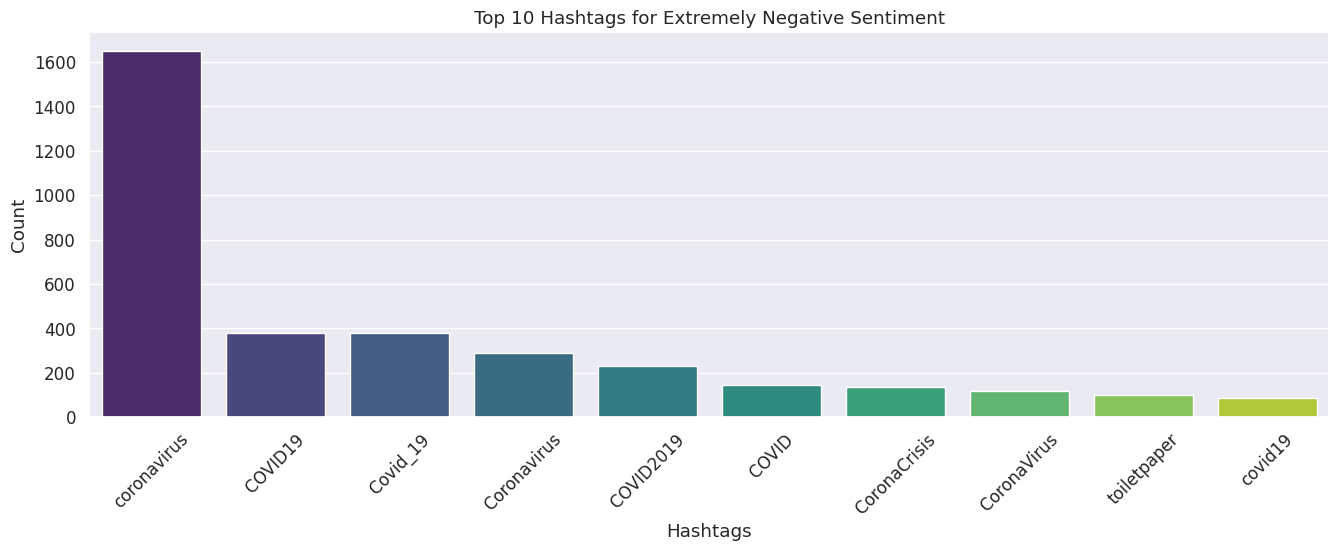

In [ ]:
# Plot top 10 hashtags for each sentiment category
plot_top_hashtags(HT_Extremely_Positive, 'Extremely Positive')
plot_top_hashtags(HT_Positive, 'Positive')
plot_top_hashtags(HT_Neutral, 'Neutral')
plot_top_hashtags(HT_Negative, 'Negative')
plot_top_hashtags(HT_Extremely_Negative, 'Extremely Negative')

# ***Common words used in the tweets: Analysis using WordCloud***

In [ ]:
# Define a function to generate and display word clouds
def generate_word_cloud(sentiment=None):
    # Filter tweets based on sentiment, if specified
    if sentiment:
        filtered_tweets = df['Tweet'][df['Sentiment'] == sentiment]
        title = f"Word Cloud for {sentiment} Sentiment"
    else:
        filtered_tweets = df['Tweet']
        title = "Word Cloud for Entire Dataset"

    # Concatenate all filtered tweets into a single string
    text = ' '.join(filtered_tweets)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title)
    plt.show()


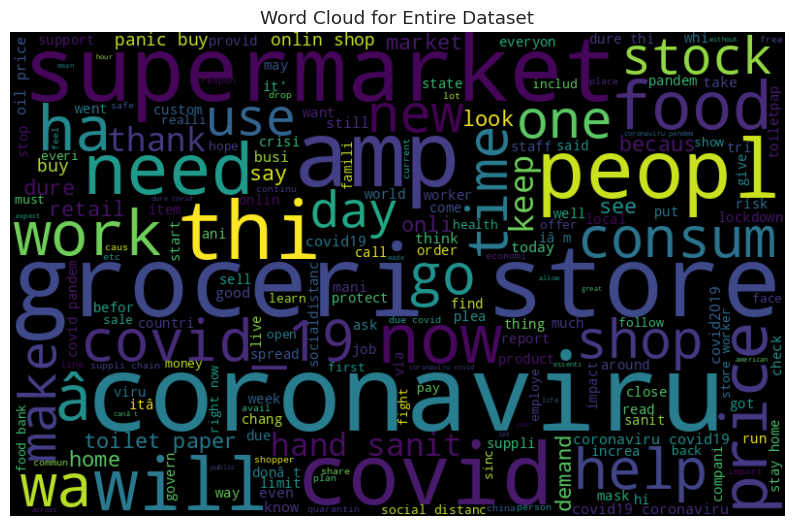

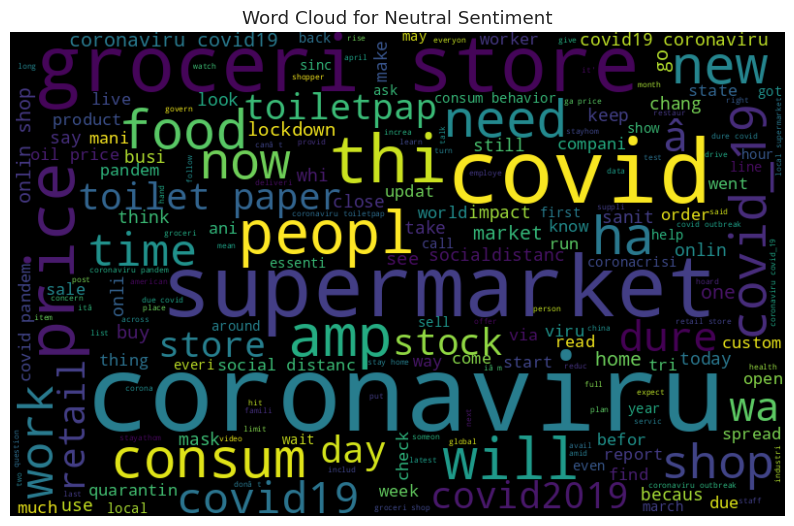

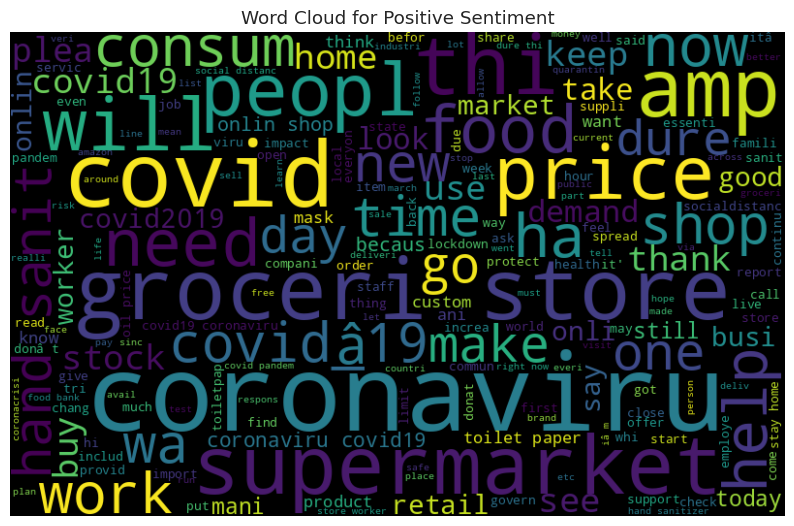

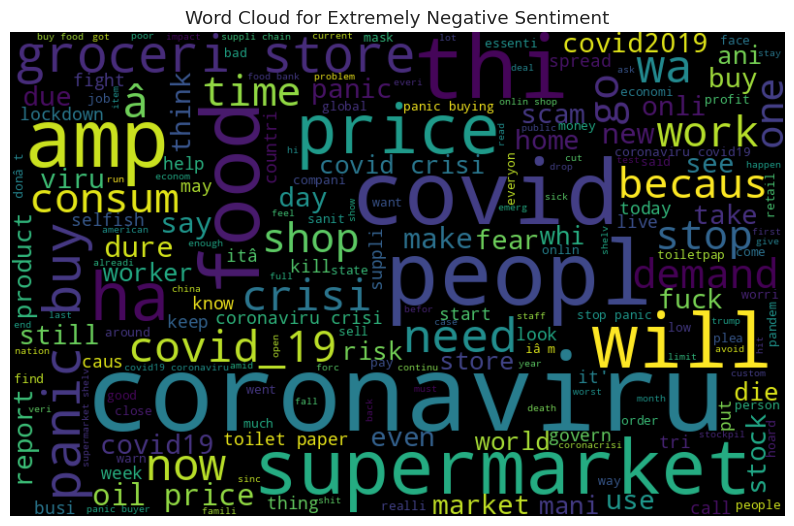

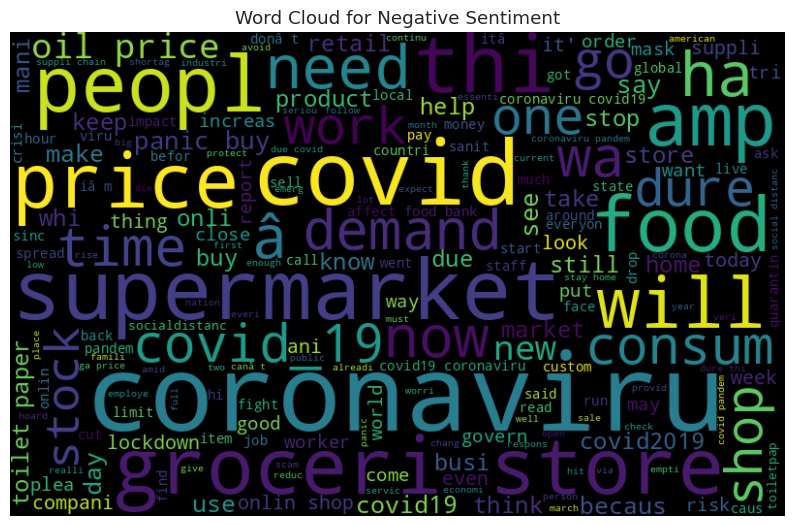

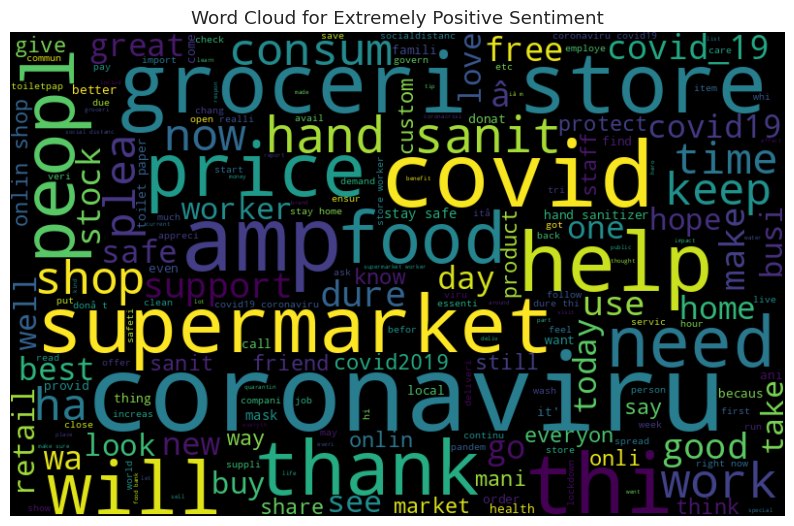

In [ ]:
from wordcloud import WordCloud
# Generate word cloud for entire dataset
generate_word_cloud()

# Generate word clouds for each sentiment category
sentiments = df['Sentiment'].unique()
for sentiment in sentiments:
    generate_word_cloud(sentiment)

# ***Extract Features from Cleaned Tweets***

In [ ]:
# Extracting features from cleaned tweets
new_df = df[['Tweet', 'Sentiment']]

In [ ]:
# Displaying the first few rows of the new dataframe
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone...,Positive
2,"coronaviru australia: woolworth give elderly, ...",Positive
3,food stock not the onli one which empty... ple...,Positive
4,"me, readi supermarket dure the #covid19 outbre...",Extremely Negative


In [ ]:
# Counting the occurrences of each sentiment category
new_df['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [ ]:
# Converting tweets to lowercase
new_df['Tweet'] = new_df['Tweet'].str.lower()

<ipython-input-31-ca0d9623ed27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Tweet'] = new_df['Tweet'].str.lower()


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
new_df['Tweet'] = new_df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

<ipython-input-33-d40142d1441b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Tweet'] = new_df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [ ]:
# Displaying the first few rows of the dataframe after removing stopwords
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk neighbour famili exchang phone numb...,Positive
2,"coronaviru australia: woolworth give elderly, ...",Positive
3,"food stock onli one empty... please, panic, en...",Positive
4,"me, readi supermarket dure #covid19 outbreak. ...",Extremely Negative


In [ ]:
# Checking for null values
new_df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [ ]:
# Displaying more rows to ensure stopwords are removed
new_df.head(5)

,Tweet,Sentiment
0,,Neutral
1,advic talk neighbour famili exchang phone numb...,Positive
2,"coronaviru australia: woolworth give elderly, ...",Positive
3,"food stock onli one empty... please, panic, en...",Positive
4,"me, readi supermarket dure #covid19 outbreak. ...",Extremely Negative


## ***Dataset Split into Training And Testing Dataset- For Multiclass Classification***

In [ ]:
# Splitting the dataset into training and testing sets
train, valid = train_test_split(new_df, test_size=0.2, random_state=0, stratify=new_df.Sentiment.values)

print("Train shape:", train.shape)
print("Validation shape:", valid.shape)


Train shape: (32925, 2)
Validation shape: (8232, 2)


In [ ]:
# Creating a list of stopwords
stop = list(stopwords.words('english'))

In [ ]:
# Initializing the CountVectorizer
vectorizer = CountVectorizer(decode_error='replace', stop_words=stop)

In [ ]:
# Transforming the training and validation tweets into vectors
X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

# Extracting the target variables
y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

In [ ]:
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (32925, 35984)
X_valid shape: (8232, 35984)
y_train shape: (32925,)
y_valid shape: (8232,)


## **ML Models for MULTICLASS Classification**

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.3 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [ ]:
def train_and_evaluate_nb(X_train, y_train, X_valid, y_valid):
    naiveByes_clf = MultinomialNB()
    naiveByes_clf.fit(X_train, y_train)
    NB_prediction = naiveByes_clf.predict(X_valid)
    NB_accuracy = accuracy_score(y_valid, NB_prediction)
    print("Training accuracy Score    : ", naiveByes_clf.score(X_train, y_train))
    print("Validation accuracy Score : ", NB_accuracy)
    print(classification_report(NB_prediction, y_valid))
    return NB_accuracy

In [ ]:
def train_and_evaluate_sgd(X_train, y_train, X_valid, y_valid):
    sgd_clf = SGDClassifier(loss='hinge', penalty='l2', random_state=0)
    sgd_clf.fit(X_train, y_train)
    sgd_prediction = sgd_clf.predict(X_valid)
    sgd_accuracy = accuracy_score(y_valid, sgd_prediction)
    print("Training accuracy Score    : ", sgd_clf.score(X_train, y_train))
    print("Validation accuracy Score : ", sgd_accuracy)
    print(classification_report(sgd_prediction, y_valid))
    return sgd_accuracy


In [ ]:
def train_and_evaluate_rf(X_train, y_train, X_valid, y_valid):
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    rf_prediction = rf_clf.predict(X_valid)
    rf_accuracy = accuracy_score(y_valid, rf_prediction)
    print("Training accuracy Score    : ", rf_clf.score(X_train, y_train))
    print("Validation accuracy Score : ", rf_accuracy)
    print(classification_report(rf_prediction, y_valid))
    return rf_accuracy


In [ ]:
def train_and_evaluate_svc(X_train, y_train, X_valid, y_valid):
    svc = SVC()
    svc.fit(X_train, y_train)
    svc_prediction = svc.predict(X_valid)
    svc_accuracy = accuracy_score(y_valid, svc_prediction)
    print("Training accuracy Score    : ", svc.score(X_train, y_train))
    print("Validation accuracy Score : ", svc_accuracy)
    print(classification_report(svc_prediction, y_valid))
    return svc_accuracy


In [ ]:
def train_and_evaluate_logreg(X_train, y_train, X_valid, y_valid):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    logreg_prediction = logreg.predict(X_valid)
    logreg_accuracy = accuracy_score(y_valid, logreg_prediction)
    print("Training accuracy Score    : ", logreg.score(X_train, y_train))
    print("Validation accuracy Score : ", logreg_accuracy)
    print(classification_report(logreg_prediction, y_valid))
    return logreg_accuracy


In [ ]:
def train_and_evaluate_catboost(X_train, y_train, X_valid, y_valid):
    clf2 = CatBoostClassifier(verbose=0)
    clf2.fit(X_train, y_train, eval_set=(X_valid, y_valid))
    print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
    print('CatBoost model parameters:')
    print(clf2.get_params())
    catboost_prediction = clf2.predict(X_valid)
    catboost_accuracy = accuracy_score(y_valid, catboost_prediction)
    print("Training accuracy Score    : ", clf2.score(X_train, y_train))
    print("Validation accuracy Score : ", catboost_accuracy)
    print(classification_report(catboost_prediction, y_valid))
    return catboost_accuracy


In [ ]:
def train_and_evaluate_all_classifiers(X_train, y_train, X_valid, y_valid):
    accuracies = {}
    print("Naive Bayes Classifier:")
    accuracies['NB_accuracy'] = train_and_evaluate_nb(X_train, y_train, X_valid, y_valid)
    print("\nSGD Classifier:")
    accuracies['sgd_accuracy'] = train_and_evaluate_sgd(X_train, y_train, X_valid, y_valid)
    print("\nRandom Forest Classifier:")
    accuracies['rf_accuracy'] = train_and_evaluate_rf(X_train, y_train, X_valid, y_valid)
    print("\nSupport Vector Machine:")
    accuracies['svc_accuracy'] = train_and_evaluate_svc(X_train, y_train, X_valid, y_valid)
    print("\nLogistic Regression:")
    accuracies['logreg_accuracy'] = train_and_evaluate_logreg(X_train, y_train, X_valid, y_valid)
    print("\nCatBoost Classifier:")
    accuracies['catboost_accuracy'] = train_and_evaluate_catboost(X_train, y_train, X_valid, y_valid)
    return accuracies


In [ ]:
# Call the function to train and evaluate all classifiers
accuracies = train_and_evaluate_all_classifiers(X_train, y_train, X_valid, y_valid)
print("\nAccuracies:", accuracies)

Naive Bayes Classifier:
Training accuracy Score    :  0.718663629460896
Validation accuracy Score :  0.4684159378036929
                    precision    recall  f1-score   support

Extremely Negative       0.33      0.58      0.42       614
Extremely Positive       0.39      0.59      0.47       870
          Negative       0.53      0.42      0.47      2487
           Neutral       0.31      0.68      0.42       697
          Positive       0.64      0.41      0.50      3564

          accuracy                           0.47      8232
         macro avg       0.44      0.54      0.46      8232
      weighted avg       0.53      0.47      0.47      8232


SGD Classifier:
Training accuracy Score    :  0.856826119969628
Validation accuracy Score :  0.5547862001943634
                    precision    recall  f1-score   support

Extremely Negative       0.65      0.61      0.63      1169
Extremely Positive       0.68      0.62      0.65      1446
          Negative       0.42      0.49    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy Score    :  0.9151404707668944
Validation accuracy Score :  0.6010689990281827
                    precision    recall  f1-score   support

Extremely Negative       0.61      0.66      0.63      1009
Extremely Positive       0.61      0.70      0.65      1166
          Negative       0.52      0.54      0.53      1910
           Neutral       0.71      0.62      0.66      1774
          Positive       0.58      0.56      0.57      2373

          accuracy                           0.60      8232
         macro avg       0.61      0.62      0.61      8232
      weighted avg       0.60      0.60      0.60      8232


CatBoost Classifier:
CatBoost model is fitted: True
CatBoost model parameters:
{'verbose': 0}
Training accuracy Score    :  0.6570387243735764
Validation accuracy Score :  0.609572400388727
                    precision    recall  f1-score   support

Extremely Negative       0.52      0.70      0.60       820
Extremely Positive       0.55      0.76      0.6

In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## ***ML MODELS CLASSIFIER TEST ACCURACY***

In [ ]:
# Store accuracies in a DataFrame and sort them
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression',
              'Random Forest', 'Naive Bayes',
              'Stochastic Gradient Decent', 'CatBoost'],
    'Test accuracy': [accuracies['svc_accuracy'], accuracies['logreg_accuracy'],
                      accuracies['rf_accuracy'], accuracies['NB_accuracy'],
                      accuracies['sgd_accuracy'], accuracies['catboost_accuracy']]
})

print(models.sort_values(by='Test accuracy', ascending=False))

# Convert Multiclass Classification into Binary Classification
CATBOOST = new_df[['Tweet', 'Sentiment']].copy()

# Replace sentiment labels with binary labels
CATBOOST["Sentiment"] = CATBOOST["Sentiment"].replace({
    'Positive': 1, 'Extremely Positive': 1,
    'Neutral': 1, 'Negative': 0, 'Extremely Negative': 0
})

print(CATBOOST.head(2))

# Print the distribution of the binary sentiment labels
print(CATBOOST['Sentiment'].value_counts())

X = CATBOOST.drop('Sentiment', axis=1)
y = CATBOOST['Sentiment']

# Download NLTK stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

# Remove stopwords from the tweets
CATBOOST['Tweet'] = CATBOOST['Tweet'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in stop]))

print(CATBOOST.head(2))

                        Model  Test accuracy
5                    CatBoost       0.609572
1         Logistic Regression       0.601069
0     Support Vector Machines       0.594752
4  Stochastic Gradient Decent       0.554786
2               Random Forest       0.549927
3                 Naive Bayes       0.468416
                                               Tweet  Sentiment
0                                                             1
1  advic talk neighbour famili exchang phone numb...          1
Sentiment
1    25759
0    15398
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                               Tweet  Sentiment
0                                                             1
1  advic talk neighbour famili exchang phone numb...          1


In [ ]:
# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## ***COUNT VECTORIZER***

In [ ]:
# Define a function to preprocess data
def preprocess_data(df):
    stop = stopwords.words('english')
    df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in stop]))
    return df

# Preprocess the data
CATBOOST = preprocess_data(CATBOOST)

# Split the data
train, valid = train_test_split(CATBOOST, test_size=0.2, random_state=0, stratify=CATBOOST.Sentiment.values)
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (32925, 2)
valid shape :  (8232, 2)


In [ ]:
# Vectorize the tweets
vectorizer = CountVectorizer(decode_error='replace', stop_words=stopwords.words('english'))
X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)
y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_valid.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (32925, 36044)
X_valid.shape :  (8232, 36044)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


## ***ML MODEL CLASSIFIER FOR BINARY CLASSIFICATION***

In [ ]:
# Define a function to train and evaluate each classifier
def train_and_evaluate_classifier(clf, X_train, y_train, X_valid, y_valid, clf_name="Classifier"):
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, prediction)
    print(f"{clf_name} Training accuracy Score    : ", clf.score(X_train, y_train))
    print(f"{clf_name} Validation accuracy Score : ", accuracy)
    print(classification_report(prediction, y_valid))
    return accuracy

# Train and evaluate classifiers
accuracies = {}

In [ ]:
print("Naive Bayes Classifier:")
accuracies['NB_accuracy'] = train_and_evaluate_classifier(MultinomialNB(), X_train, y_train, X_valid, y_valid, "Naive Bayes")

print("\nRandom Forest Classifier:")
accuracies['rf_accuracy'] = train_and_evaluate_classifier(RandomForestClassifier(), X_train, y_train, X_valid, y_valid, "Random Forest")

print("\nLogistic Regression:")
accuracies['logreg_accuracy'] = train_and_evaluate_classifier(LogisticRegression(), X_train, y_train, X_valid, y_valid, "Logistic Regression")

print("\nCatBoost Classifier:")
clf2 = CatBoostClassifier(verbose=0)
accuracies['catboost_accuracy'] = train_and_evaluate_classifier(clf2, X_train, y_train, X_valid, y_valid, "CatBoost")

print("\nXGBoost Classifier:")
accuracies['xgb_accuracy'] = train_and_evaluate_classifier(xgb.XGBClassifier(), X_train, y_train, X_valid, y_valid, "XGBoost")

print("\nSupport Vector Machine:")
accuracies['svc_accuracy'] = train_and_evaluate_classifier(SVC(), X_train, y_train, X_valid, y_valid, "Support Vector Machine")


Naive Bayes Classifier:
Naive Bayes Training accuracy Score    :  0.8706454062262718
Naive Bayes Validation accuracy Score :  0.7879008746355685
              precision    recall  f1-score   support

           0       0.68      0.74      0.70      2836
           1       0.85      0.82      0.83      5396

    accuracy                           0.79      8232
   macro avg       0.77      0.78      0.77      8232
weighted avg       0.79      0.79      0.79      8232


Random Forest Classifier:
Random Forest Training accuracy Score    :  0.9987243735763098
Random Forest Validation accuracy Score :  0.8281098153547133
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      2547
           1       0.91      0.83      0.87      5685

    accuracy                           0.83      8232
   macro avg       0.80      0.83      0.81      8232
weighted avg       0.84      0.83      0.83      8232


Logistic Regression:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Training accuracy Score    :  0.9490356871678056
Logistic Regression Validation accuracy Score :  0.8544703595724004
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      2776
           1       0.91      0.86      0.89      5456

    accuracy                           0.85      8232
   macro avg       0.83      0.85      0.84      8232
weighted avg       0.86      0.85      0.86      8232


CatBoost Classifier:
CatBoost Training accuracy Score    :  0.8488990129081245
CatBoost Validation accuracy Score :  0.8311467444120505
              precision    recall  f1-score   support

           0       0.66      0.85      0.75      2406
           1       0.93      0.82      0.87      5826

    accuracy                           0.83      8232
   macro avg       0.80      0.84      0.81      8232
weighted avg       0.85      0.83      0.84      8232


XGBoost Classifier:
XGBoost Training accuracy Score    :  0.84528473804

# ***Deciding Model***

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, log_loss

# Function to train and evaluate SGD Classifier
def evaluate_sgd_classifier(X_train, y_train, X_valid, y_valid):
    # Initialize and train the model
    sgd_clf = SGDClassifier(loss='hinge', penalty='l2', random_state=0)
    sgd_clf.fit(X_train, y_train)

    # Predictions
    train_class_preds = sgd_clf.predict(X_train)
    test_class_preds = sgd_clf.predict(X_valid)

    # Accuracy
    training_accuracy = sgd_clf.score(X_train, y_train)
    validation_accuracy = accuracy_score(y_valid, test_class_preds)
    print("Training accuracy Score    : ", training_accuracy)
    print("Validation accuracy Score : ", validation_accuracy)
    print(classification_report(test_class_preds, y_valid))

    # Confusion Matrix
    labels = ['Negative', 'Positive']
    cm = confusion_matrix(y_train, train_class_preds)
    print("Confusion Matrix:\n", cm)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues')  # annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix - Training Set')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

    # Overall Accuracy
    overall_accuracy = accuracy_score(y_valid, test_class_preds)
    print('Overall accuracy:', overall_accuracy)

    # F1 Score
    f1 = f1_score(y_valid, test_class_preds, average="macro")
    print('F1 Score:', f1)

    # Recall Score
    recall = recall_score(y_valid, test_class_preds, average='macro')
    print('Recall Score:', recall)

    # Classification Report
    class_report = classification_report(y_valid, test_class_preds)
    print("Classification Report:\n", class_report)

    # Confusion Matrix for Validation Set
    cm_valid = confusion_matrix(y_valid, test_class_preds)
    print("Validation Set Confusion Matrix:\n", cm_valid)

    return {
        'training_accuracy': training_accuracy,
        'validation_accuracy': validation_accuracy,
        'f1_score': f1,
        'recall_score': recall,
        'classification_report': class_report,
        'confusion_matrix': cm_valid
    }


Training accuracy Score    :  0.9455125284738041
Validation accuracy Score :  0.859572400388727
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      2880
           1       0.91      0.87      0.89      5352

    accuracy                           0.86      8232
   macro avg       0.84      0.85      0.85      8232
weighted avg       0.86      0.86      0.86      8232

Confusion Matrix:
 [[11184  1134]
 [  660 19947]]


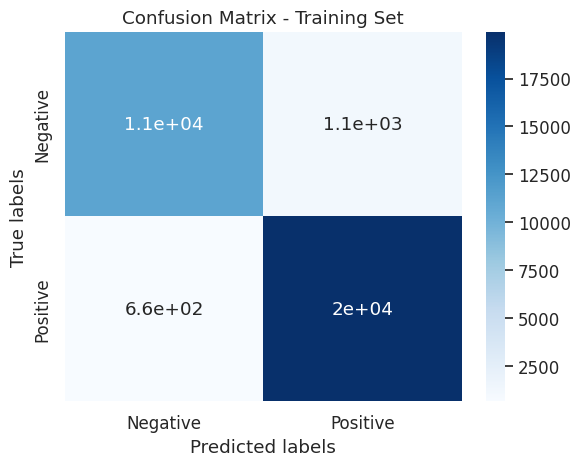

Overall accuracy: 0.859572400388727
F1 Score: 0.8479934777163829
Recall Score: 0.8435453133822699
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81      3080
           1       0.87      0.91      0.89      5152

    accuracy                           0.86      8232
   macro avg       0.85      0.84      0.85      8232
weighted avg       0.86      0.86      0.86      8232

Validation Set Confusion Matrix:
 [[2402  678]
 [ 478 4674]]
training_accuracy: 0.9455125284738041
validation_accuracy: 0.859572400388727
f1_score: 0.8479934777163829
recall_score: 0.8435453133822699


In [ ]:

# Call the function with your data
results = evaluate_sgd_classifier(X_train, y_train, X_valid, y_valid)

# Display results in a readable format
for key, value in results.items():
    if key != 'classification_report' and key != 'confusion_matrix':
        print(f"{key}: {value}")

## ***EVALUATION OF EVERY BINARY CLASSIFICATION MODELS***

In [ ]:

# Function to evaluate a given classifier
def evaluate_model(clf, model_name, X_train, y_train, X_valid, y_valid):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, predictions)
    print(f"{model_name} - Training Accuracy: {clf.score(X_train, y_train)}")
    print(f"{model_name} - Validation Accuracy: {accuracy}")
    print(classification_report(y_valid, predictions))
    return accuracy

# List to store model names and accuracies
model_names = [
    "Support Vector Machines", "Logistic Regression",
    "Random Forest", "Naive Bayes",
    "Stochastic Gradient Descent", "XGBoost", "CatBoost"
]



# ***ML Model test accuracy in descending order***

In [ ]:
accuracies = []

# Train and evaluate each model
svc = SVC()
svc_accuracy = evaluate_model(svc, "Support Vector Machines", X_train, y_train, X_valid, y_valid)
accuracies.append(svc_accuracy)

logreg = LogisticRegression(max_iter=1000)
logreg_accuracy = evaluate_model(logreg, "Logistic Regression", X_train, y_train, X_valid, y_valid)
accuracies.append(logreg_accuracy)

rf_clf = RandomForestClassifier()
rf_accuracy = evaluate_model(rf_clf, "Random Forest", X_train, y_train, X_valid, y_valid)
accuracies.append(rf_accuracy)

naive_bayes = MultinomialNB()
NB_accuracy = evaluate_model(naive_bayes, "Naive Bayes", X_train, y_train, X_valid, y_valid)
accuracies.append(NB_accuracy)

sgd_clf = SGDClassifier(loss='hinge', penalty='l2', random_state=0)
sgd_accuracy = evaluate_model(sgd_clf, "Stochastic Gradient Descent", X_train, y_train, X_valid, y_valid)
accuracies.append(sgd_accuracy)

xgboost_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_accuracy = evaluate_model(xgboost_clf, "XGBoost", X_train, y_train, X_valid, y_valid)
accuracies.append(xgb_accuracy)

catboost_clf = CatBoostClassifier(verbose=0)
catboost_accuracy = evaluate_model(catboost_clf, "CatBoost", X_train, y_train, X_valid, y_valid)
accuracies.append(catboost_accuracy)

# Create DataFrame to sort and display model accuracies
models = pd.DataFrame({
    'Model': model_names,
    'Test accuracy': accuracies
})

sorted_models = models.sort_values(by='Test accuracy', ascending=False)
print(sorted_models)

Support Vector Machines - Training Accuracy: 0.9576917236142749
Support Vector Machines - Validation Accuracy: 0.8367346938775511
              precision    recall  f1-score   support

           0       0.86      0.67      0.76      3080
           1       0.83      0.93      0.88      5152

    accuracy                           0.84      8232
   macro avg       0.84      0.80      0.82      8232
weighted avg       0.84      0.84      0.83      8232

Logistic Regression - Training Accuracy: 0.9488838268792711
Logistic Regression - Validation Accuracy: 0.8544703595724004
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      3080
           1       0.86      0.91      0.89      5152

    accuracy                           0.85      8232
   macro avg       0.85      0.83      0.84      8232
weighted avg       0.85      0.85      0.85      8232

Random Forest - Training Accuracy: 0.9987243735763098
Random Forest - Validation Accuracy: 0.8